In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam


### Load the data

In [62]:
fake_news=pd.read_csv("ML KNN Overview Fake.txt", header=None)
true_news=pd.read_csv("ML KNN Overview Real.txt", header=None)

In [63]:
fake_news

,0
0,trump warns of vote flipping on machines
1,this election is not about trump its about a g...
2,more on trump populism and how it can be contr...
3,trump bollywood ad meant to sway indian americ...
4,dems could be up on charges for inciting trump...
...,...
1293,what happens if trump loses the election what ...
1294,latest poll shows trump with 4 point lead in f...
1295,breaking donald trump makes major clinton indi...
1296,no hate crimes have not intensified since trum...


## Set the columns name 'text'

In [64]:
fake_news.columns=['text']
true_news.columns=['text']

In [65]:
true_news['label']=1
fake_news['label']=0

## Combine the dataset

In [66]:
news_df=pd.concat([fake_news,true_news])

In [67]:
# Shuffle the dataset
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [68]:

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

news_df['text'] = news_df['text'].apply(preprocess_text)

## Spliting the data

In [69]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], news_df['label'], test_size=0.2, random_state=42)

## Vectorization

In [70]:
vectorizer= TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define function to plot training history


In [71]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

In [72]:
# Function to plot ROC curve
def plot_roc_curve(y_test,y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [73]:
# Function to evaluate models
def evaluate_model(model, X_trai,y_train,X_test,y_test):
    model.fit(X_trai,y_train)
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:,1]
    
    accuracy=accuracy_score(y_test,y_pred)
    cm=confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    
    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix')
    print(cm)
    print(f'Report of Confusion Matrix')
    print(report)
    plot_roc_curve(y_test,y_pred_prob)

## Logistic Regression 

Logistic Regression
Accuracy: 0.8042813455657493
Confusion Matrix
[[192  72]
 [ 56 334]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       264
           1       0.82      0.86      0.84       390

    accuracy                           0.80       654
   macro avg       0.80      0.79      0.79       654
weighted avg       0.80      0.80      0.80       654



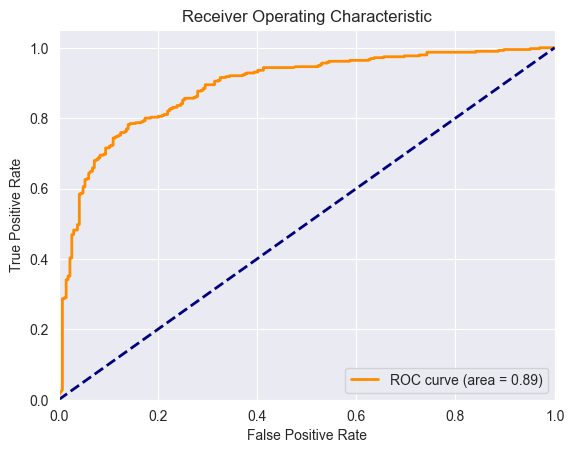

In [74]:
print("Logistic Regression")
logreg=LogisticRegression(max_iter=1000)
evaluate_model(logreg,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Multinomial Naive Bayes

Multinomial Naive Bayes
Accuracy: 0.8058103975535168
Confusion Matrix
[[188  76]
 [ 51 339]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       264
           1       0.82      0.87      0.84       390

    accuracy                           0.81       654
   macro avg       0.80      0.79      0.79       654
weighted avg       0.80      0.81      0.80       654



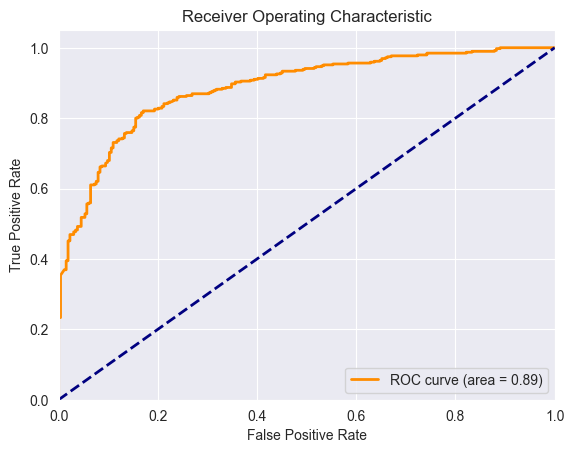

In [75]:
print("Multinomial Naive Bayes")
mnb=MultinomialNB()
evaluate_model(mnb,X_train_tfidf,y_train,X_test_tfidf,y_test)


## Support Vector Machine

Support Vector Machine
Accuracy: 0.8180428134556575
Confusion Matrix
[[196  68]
 [ 51 339]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       264
           1       0.83      0.87      0.85       390

    accuracy                           0.82       654
   macro avg       0.81      0.81      0.81       654
weighted avg       0.82      0.82      0.82       654



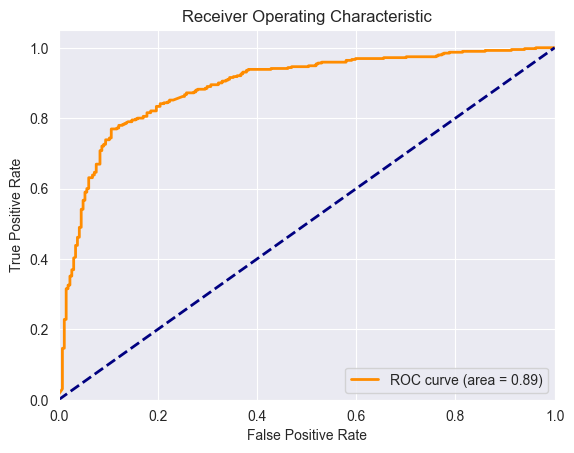

In [76]:
print("Support Vector Machine")
svc=SVC(probability=True)
evaluate_model(svc,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Random Forest

Random Forest
Accuracy: 0.8119266055045872
Confusion Matrix
[[189  75]
 [ 48 342]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.80      0.72      0.75       264
           1       0.82      0.88      0.85       390

    accuracy                           0.81       654
   macro avg       0.81      0.80      0.80       654
weighted avg       0.81      0.81      0.81       654



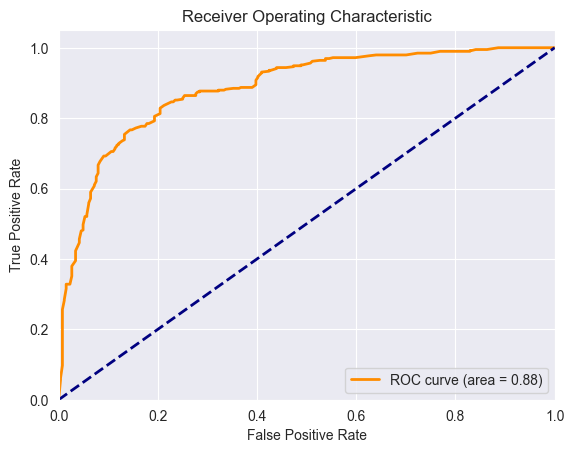

In [77]:
print("Random Forest")
rfc=RandomForestClassifier(n_estimators=100)
evaluate_model(rfc,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Neural Network

Neural Network
Epoch 1/100


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5613 - loss: 0.6764 - val_accuracy: 0.5946 - val_loss: 0.6453
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6104 - loss: 0.6100 - val_accuracy: 0.7151 - val_loss: 0.5520
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8013 - loss: 0.4730 - val_accuracy: 0.7878 - val_loss: 0.4519
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.3273 - val_accuracy: 0.7801 - val_loss: 0.4792
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8781 - loss: 0.2740 - val_accuracy: 0.7878 - val_loss: 0.4796
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.2268 - val_accuracy: 0.7897 - val_loss: 0.4923
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9239 - loss: 0.1965 - val_accuracy: 0.7744 - val_loss: 0.5214
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9324 - loss: 0.1792 - val_accuracy: 0.7859 - val_loss: 0.

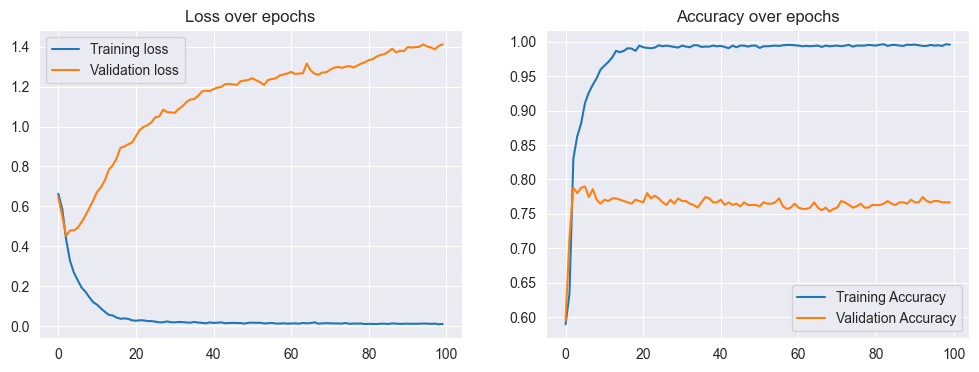

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8058103975535168
Confusion Matrix: [[187  77]
 [ 50 340]]
Classification Report:               precision    recall  f1-score   support

           0       0.79      0.71      0.75       264
           1       0.82      0.87      0.84       390

    accuracy                           0.81       654
   macro avg       0.80      0.79      0.79       654
weighted avg       0.80      0.81      0.80       654



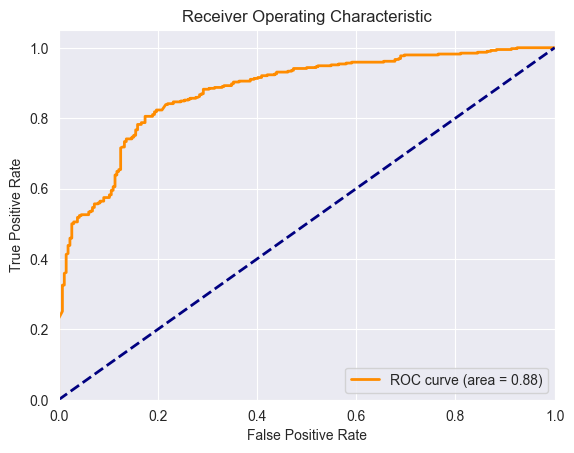

In [79]:
print("Neural Network")
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(512,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
    return model

nn_model=create_nn_model(X_train_tfidf.shape[1])
history=History()
nn_model.fit(X_train_tfidf.toarray(),y_train,epochs=100, batch_size=128,validation_split=0.2,callbacks=[history])
plot_history(history)

# Evaluate Neural Network

y_pred_prob_nn=nn_model.predict(X_test_tfidf.toarray()).ravel()
y_pred_nn=(y_pred_prob_nn>0.5).astype(int)
print(f'Accuracy: {accuracy_score(y_test,y_pred_nn)}')
print(f'Confusion Matrix: {confusion_matrix(y_test,y_pred_nn)}')
print(f'Classification Report: {classification_report(y_test,y_pred_nn)}')
plot_roc_curve(y_test,y_pred_prob_nn)